## HW \#6: Multimodal Localization with Particle Filters
<p style="position: relative; top:-20px; margin: 0px; padding 0px; font-size: 12px">(C) 2023 Bradley Hayes and Christoffer Heckman, University of Colorado Boulder</p>
<p style="position: relative; top:-20px; margin: 0px; padding 0px; font-size: 4px">v1.0</p>

**Deliverable**: A completed Jupyter notebook in both ipynb and PDF format, uploaded to Canvas. The starter code will generate the necessary images, please do not modify any code that visualizes results.

**Graduate Students**: Please complete the entire assignment.

**Undergraduate Students**: Please complete questions that do not have **(GRAD)** next to them. (You may attempt these for extra credit)

### Introduction
Particle filters, also known as Sequential Monte Carlo methods, are a powerful technique for estimating the state of a dynamic system when given partial, noisy observations. In the context of robotics, particle filters can be used for tasks such as localization, mapping, and simultaneous localization and mapping (SLAM).

### Overview of Particle Filters
A particle filter uses a set of random samples, or particles, to represent the probability distribution of the system's state. Each particle represents a hypothesis about the true state of the system. The particle filter algorithm iteratively updates the particle set based on new observations and the system's dynamics. In this assignment, we will be using a fixed size set of particles and we will resample using a balance of existing estimates and newly sampled estimates. 

The algorithm can be broken down into the following steps:

- **Initialization**: Generate an initial set of particles representing the prior distribution of the system's state.
- **Prediction**: Update the particles based on the system's dynamics and control inputs.
- **Update**: Take sensor observations and update the particle weights based on the likelihood of the observed measurements.
- **Resampling**: Replace low-weight particles with newly sampled particles, eliminating highly unlikely particles, balancing between resampling using more probable existing ones and new guesses elsewhere in the state space.

At each timestep, the **Prediction**, **Update**, and **Resampling** steps are performed, keeping an up-to-date set of weighted state estimates forming a multimodal distribution that is updated with a bounded compute cost per cycle.

### Part 1: Particle Filter Foundations

In this section, you will implement a generic `ParticleFilter` class that will be usable with different motion and observation models for localization tasks. As such, it is important that you implement your solution to work for any dimensionality of world passed in. Your code should be able to determine the dimensionality of the environment from the `world_size` variable, which will be given in the form of a matrix where each row i gives the minimum and maximum allowable values (columns 0 and 1, respectively) for the ith dimension of the world.

Within the simulations, your Particle Filter functions will be called in this order:
- Resample
- Predict
- Update

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib.lines import Line2D
import time
import math

In [26]:
class LinearParticleFilter:
    def __init__(self, num_particles: int, world_size: np.ndarray, landmarks: np.ndarray, motion_noise_std: float, sensor_noise_std: float):
        '''
        num_particles: Number of particles tracked by the filter at every timestep
        world_size: Numpy array with row entries [min,max] value
        landmarks: Numpy array where each row contains coordinates for the centroid of a landmark
        motion_noise_std: Standard deviation of motion model noise term
        sensor_noise_std: Standard deviation of sensor model noise term
        '''
        self.J=num_particles
        self.world_size=world_size
        self.motion_noise_std=motion_noise_std
        self.sensor_noise_std=sensor_noise_std
        self.particles=np.array([[self.sample_random_state()] for _ in range(self.J)])
        self.weights=np.array([[1/self.J] for _ in range(self.J)])
        self.landmarks=landmarks
        self.indexArr=[i for i in range(self.J)]

    def sample_random_state(self) -> float:
        '''
        Returns a random state within world_size bounds
        '''
        if isinstance(self.world_size[0],list)==False:
            return [np.random.uniform(self.world_size[0],self.world_size[1])]
        sz=len(self.world_size)
        rState=[np.random.uniform(self.world_size[i][0],self.world_size[i][1]) for i in range(sz)]
        return rState
        
    def predict(self, u: np.ndarray):
        '''
        u: Motion update (np.ndarray indicating movement distance)
        motion_noise_std: Motion model uncertainty
        Update particle positions by u, while incorporating 0-mean Gaussian noise with stdev=motion_noise_std
        '''
        for id,p in enumerate(self.particles):
            self.particles[id]=np.clip(p+u+np.random.normal(0,self.motion_noise_std),min(self.world_size),max(self.world_size))
        
    def update(self, z: np.ndarray):
        '''
        z: Distance from agent to the nearest observable landmark
        Update particle weights using sensor reading z, which gives the distance to the nearest landmark.
        Particle weights should be updated using a Gaussian model centered at z. 
        Each weight must be the probability mass within a Gaussian, based on the difference between
        that particle's distance to the closest landmark and the distribution's mean (z),
        with stddev=sensor_noise_std
        
        All particle weights must be normalized before returning from this function
        '''
        def sensor_model(x):     
            if isinstance(z,float):
                eta=1/(self.sensor_noise_std*np.sqrt(2*np.pi))
                return eta*np.exp(-0.5*((z-x[0])/self.sensor_noise_std)**2)
        wt=[0]*self.J
        for i_o,x in enumerate(self.particles):
            zp=min([abs(x-self.landmarks[i]) for i in range(len(self.landmarks))])
            wt[i_o]=sensor_model(zp)
        # mm=min(self.weights)
        # try:
        #     assert mm>=0
        # except AssertionError as e:
        #     print(z)
        alpha=0.1 #weight given to history.
        self.weights=alpha*self.weights+(1-alpha)*np.array(wt).reshape(self.J,1)
        n_sum=np.sum(self.weights,axis=0)
        self.weights=self.weights/n_sum
        # My code is written for multi-dimensional state, but the prints don't take that into consideration so reshaping
        self.weights=self.weights.ravel()
        self.particles=self.particles.ravel()

        
    def resample(self):
        '''
        Sample new particles proportional to their weight.
        Your implementation should sample 80% of its particles from the existing batch
        and 20% of its particles should be sampled uniformly at random from the state space.

        Make sure to renormalize your particle's weights before returning
        '''
        self.weights=self.weights.reshape(-1,1)
        self.particles=self.particles.reshape(-1,1)
        # My code is written for multi-dimensional state, but the prints don't take that into consideration so reshaping
        n=int(math.ceil(self.J*0.8))
        temp=np.mean(self.weights,axis=1)
        index=[np.random.choice(self.indexArr,p=temp.tolist()) for _ in range(n)]
        reSample=[]
        for _ in index:
            reSample.append(np.array(self.particles[_]))
        m=self.J-n 
        for _ in range(m):
            reSample.append(np.array(self.sample_random_state()))
        self.particles=np.array(reSample) 

    def estimate(self) -> np.ndarray:
        '''
        Provides a state estimate based on the particles within the filter.
        Returns the state estimate within the most likely particle
        '''
        mx_wt=max(self.weights)
        equi_state=[]
        for id,wt in enumerate(self.weights):
            if mx_wt==wt:
                equi_state.append(self.particles[id])
        id=np.random.randint(0,len(equi_state))
        return np.array([equi_state[id]])
    

### Simulation Controls
You can use these sliders to change aspects of the simulations that are run. Domain Parameters control the ground truth of the actual simulation itself, whereas the Particle Filter parameters are your model of the domain. For best results, these values will match closely, but this is rarely achievable in practice.

In [27]:
from ctrls import *
display_ctrls()

### Simulation code for a 1D Linear Domain (a robot that moves along a single bounded axis)
You may play around with the initial_pos, control_sequence, and landmarks variables to build intuition for how the particle filter works in different conditions.

In [28]:
world_size = np.array([-10,10])
motion_noise_std = domain_motion_noise_slider.value
sensor_noise_std = domain_sensor_noise_slider.value
num_particles = filter_num_particles_slider.value

initial_pos = np.random.uniform(world_size[0], world_size[1])
control_sequence = [1, 1, -0.2, -0.1, 0.2, 0, 0.1, 2, .4, .2, -0.2, -0.5, -0.1, -0.1] * 3
landmarks = np.array([0,5])
# landmarks = np.array([0])
# landmarks = np.array([0,5,-2.5])

pf = LinearParticleFilter(num_particles, world_size, landmarks, filter_motion_noise_slider.value, filter_sensor_noise_slider.value)
est_poses, real_poses = run_linear_particle_filter_simulation(pf, world_size, landmarks, motion_noise_std, sensor_noise_std, initial_pos, control_sequence)


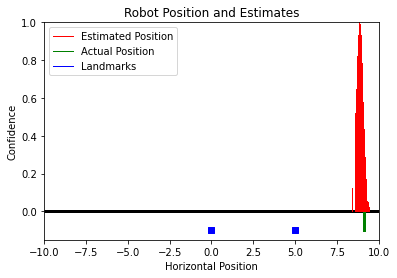

In [29]:
for rob_pos, est_pos in zip(real_poses, est_poses):
    time.sleep(0.1)
    clear_output(wait=True)
    visualize_linear_world(rob_pos, est_pos, landmarks, world_size)

### Analysis:
Edit the landmarks array above -- what happens when there's just one landmark at position 0? What if there are two landmarks? Or three? Since this simple sensor model only looks at distance to the nearest landmark, describe how increasing landmark count and the distance between them affects our position estimates.

#### Your Response:
> Since the sensor model is just looking at the closest distance to the nearest landmark, adding more landmarks will increase the uncertainty in pose estimates. Let's say [$d$] is the distance measured by the sensor to the closest landmark, if there are multiple landmarks multiple particles will statisfy the condition of being at $d$ distance away from those mulitple landmarks, so the weight distribution of particles will be more spread out and the pose estimates will be more uncertain. 

#### (GRAD) Circular World Particle Filter
Next, implement a particle filter for a robot that operates on the circumference of a circular world: landmarks will be visible from either side, but you will need to pay special attention to the fact that the coordinate system wraps around at position `0` and position `world_circumference`

In [36]:
class CircularParticleFilter:
    def __init__(self, num_particles: int, world_size: float, landmarks: np.ndarray, motion_noise_std: float, sensor_noise_std: float):
        '''
        num_particles: Number of particles tracked by the filter at every timestep
        world_size: Float describing the circumference of the robot's world
        landmarks: Numpy array where each row contains coordinates for the centroid of a landmark
        motion_noise_std: Standard deviation of motion model noise term
        sensor_noise_std: Standard deviation of sensor model noise term
        '''
        self.J=num_particles
        self.motion_noise_std=motion_noise_std
        self.sensor_noise_std=sensor_noise_std 
        self.landmarks=landmarks
        self.world_circumference=world_size 
        self.particles=np.random.uniform(0,self.world_circumference,size=(self.J))
        self.weights=np.array([(1/self.J) for _ in range(self.J)])
    def resize():
        pass
    def wrap_position(self, pos: float, world_circumference: float):
        '''
        Ensure that pos is in the range [0, world_circumference]
        '''
        return np.mod(pos, world_circumference)

    def predict(self, u: float):
        '''
        Update particle positions based on motion model
        u: Control signaling the amount of motion to enact
        '''
        self.particles=self.wrap_position(self.particles+u+np.random.normal(0,self.motion_noise_std,size=(self.J)),self.world_circumference)
        #self.pCount('p',0,self.world_circumference//2)

    def update(self, z):
        '''
        Update particle weights based on the distance to the nearest landmark using a Gaussian probability model
        (Make sure to accommodate the wrap-around!)
        
        z: Distance to nearest landmark
        '''
        def guassian(zp):
            eta=1/(self.sensor_noise_std*np.sqrt(2*np.pi))
            return eta*np.exp( -0.5*((z-zp)/self.sensor_noise_std)**2 )
        zp=np.min([np.min([np.mod(self.landmarks[i]-self.particles,self.world_circumference),\
                           np.mod(self.particles-self.landmarks[i],self.world_circumference)],axis=0)\
                           for i in range(self.landmarks.shape[0])],axis=0)
        alpha=0.05 #weight given to history.
        self.weights=alpha*self.weights+(1-alpha)*guassian(zp)
        normalize=np.sum(self.weights)
        self.weights=self.weights/normalize
        #self.pCount('u',0,self.world_circumference//2)
        
    def resample(self):
        '''
        Your implementation should sample 80% of its particles from the existing batch
        and 20% of its particles should be sampled uniformly at random from the state space.
        Remember to renormalize your particle weights when done.
        '''
        n=int(self.J*0.8)
        m=self.J-n
        indexArr=[i for i in range(self.J)]
        index=[np.random.choice(indexArr,p=self.weights.tolist()) for _ in range(n)]
        greedy_particles=np.array([self.particles[i] for i in index])
        uniform_particles=np.random.uniform(0,self.world_circumference,size=(m))
        self.particles=np.concatenate([greedy_particles,uniform_particles])
        #self.pCount('r',0,self.world_circumference//2)
        
    def pCount(self,txt,lb,ub):
        return 
        cnt=0
        for p in self.particles:
            if lb<=p and p<=ub:
                cnt+=1
        print(f'{txt}: {cnt}')

    def estimate(self) -> float:
        '''
        Returns a state estimate from the filter based on the most likely particle
        '''
        id=np.argmax(self.weights)
        return self.particles[id]
        

### 2D Circular World Setup Code

In [39]:
world_circumference = 8
motion_noise_std = domain_motion_noise_slider.value
sensor_noise_std = domain_sensor_noise_slider.value
num_particles = filter_num_particles_slider.value

initial_pos = np.random.uniform(0, world_circumference)
# control_sequence = [2, -1] * 15
# landmarks = np.array([0])
control_sequence = [1, 1, -0.2, -0.1, 0.2, 0, 0.1, 2, .4, .2, -0.2, -0.5, -0.1, -0.1] * 3
landmarks = np.array([0])
pf = CircularParticleFilter(num_particles, world_circumference, landmarks, filter_motion_noise_slider.value, filter_sensor_noise_slider.value)
est_poses, real_poses = run_circular_particle_filter_simulation(pf, world_circumference, landmarks, motion_noise_std, sensor_noise_std, initial_pos, control_sequence)

est_poses=np.array(est_poses)

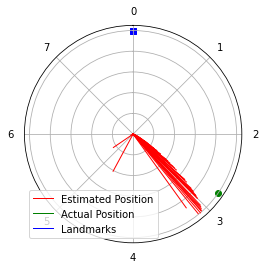

In [40]:
import time
for rob_pos, est_pos in zip(real_poses, est_poses):
    time.sleep(0.1)
    clear_output(wait=True)
    visualize_circular_world(rob_pos, est_pos, landmarks, world_circumference)
    

#### Analysis:
What happens when the size of the steps in the control sequence approach the stdev of the motion noise? What happens if the steps are much larger than the motion noise (e.g., 1 vs. 0.01)?

#### Your Response:
> If the motion model noise is increased, during the prediction step (which uses the motion model) the particles get spead out more. This spreading out of particles from few compact locations is due to the fact that after the control action our model is uncertain what is the actual pose estiamte. Since the motion model is noisy the algorithm entirely relies upon the sensor model to give a correct pose estimation. For one landmark every sensor measurement is associated with two possible pose estimate regions, therefore if the motion noise is more we get almost two equally dense regions of particles for one landmark. Less motion model noise makes one of the two pose estimate regions more dense with particles. 